# AutTextification Model + Feature Engineering

In [1]:
# -- Install libraries
!pip install transformers
!pip install llvmlite --ignore-installed
!pip install pycaret --upgrade
!pip install shap --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 35.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 61.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to bui

In [10]:
# -- Libraries
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import recall_score, f1_score, accuracy_score
from   transformers            import BertModel, BertTokenizer, AutoModelForSequenceClassification
from   torch.utils.data        import DataLoader, Dataset
from   tqdm                    import tqdm
from   pycaret.classification  import *
import pandas                  as pd
import torch.nn                as nn
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import torch
import shap

# -- Define hyperparameters
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 32
LEARNING_RATE    = 5e-5
WEIGHT_DECAY     = 0.01
EPOCHS           = 3
EN_TRAIN_DATA    = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/en'
ES_TRAIN_DATA    = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/es'

In [3]:
train_df_en = pd.read_csv('/kaggle/input/autextification/train_en.tsv', sep='\t')
train_df_en['lang'] = 'en'

train_df_es = pd.read_csv('/kaggle/input/autextification/train_es.tsv', sep='\t')
train_df_es['lang'] = 'es'

train_df = pd.concat([train_df_en, train_df_es])
train_df.reset_index(drop=True, inplace=True)
train_df['label'] = train_df['label'].apply(lambda x: 1 if x == 'generated' else 0)
train_df, test_df = train_test_split(train_df[['text', 'label']], test_size=0.2, random_state=42)

In [4]:
autextification_df = pd.read_csv('/kaggle/input/autextification-fe/autextification_fe.csv', sep=';')
autextification_df['label'] = autextification_df['label'].apply(lambda x: 1 if x == 'generated' else 0)

In [5]:
train_df_fe = autextification_df.iloc[list(train_df.index), :]
train_df_fe.reset_index(drop=True, inplace=True)
test_df_fe  = autextification_df.iloc[list(test_df.index), :]
test_df_fe.reset_index(drop=True, inplace=True)

## Feature engineering with PyCaret

In [7]:
autextification_df.drop(['id', 'text', 'lang'], axis=1, inplace=True)

In [24]:
# -- AutoML:
# ---- Train size: 80 %
# ---- Only numeric features
# ---- Add feature selection (threshold = 0.9)
# ---- Fix imbalance
pd.set_option('display.max_rows', None)
s = setup(data = autextification_df, target = 'label', numeric_features=list(autextification_df.columns)[1:], 
          feature_selection_method='classic', categorical_features = [], session_id=1234, feature_selection=True, 
          n_features_to_select=0.5, fix_imbalance=True)
best_model = compare_models(sort = 'F1', n_select=4, exclude=['lda', 'svm', 'et', 'nb'])

,Description,Value
0,Session id,1234
1,Target,label
2,Target type,Binary
3,Original data shape,"(65907, 56)"
4,Transformed data shape,"(66075, 28)"
5,Transformed train set shape,"(46302, 28)"
6,Transformed test set shape,"(19773, 28)"
7,Numeric features,55
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7851,0.8708,0.7886,0.7844,0.7864,0.5702,0.5703,19.5030
rf,Random Forest Classifier,0.7750,0.8597,0.7901,0.7681,0.7789,0.5499,0.5501,24.0680
xgboost,Extreme Gradient Boosting,0.7725,0.8567,0.7740,0.7730,0.7734,0.5450,0.5450,16.0930
lightgbm,Light Gradient Boosting Machine,0.7680,0.8541,0.7770,0.7646,0.7707,0.5360,0.5361,2.6350
gbc,Gradient Boosting Classifier,0.7286,0.8123,0.7358,0.7268,0.7312,0.4572,0.4572,27.9940
ada,Ada Boost Classifier,0.6920,0.7675,0.6864,0.6958,0.6911,0.3840,0.3841,7.9970
dt,Decision Tree Classifier,0.6761,0.6761,0.6769,0.6775,0.6771,0.3523,0.3523,2.1060
knn,K Neighbors Classifier,0.6665,0.7304,0.6319,0.6807,0.6554,0.3332,0.3341,9.6740
ridge,Ridge Classifier,0.6311,0.0000,0.6176,0.6366,0.6269,0.2623,0.2625,0.4650
lr,Logistic Regression,0.6294,0.6905,0.6171,0.6344,0.6256,0.2588,0.2589,10.9900


Processing:   0%|          | 0/56 [00:00<?, ?it/s]

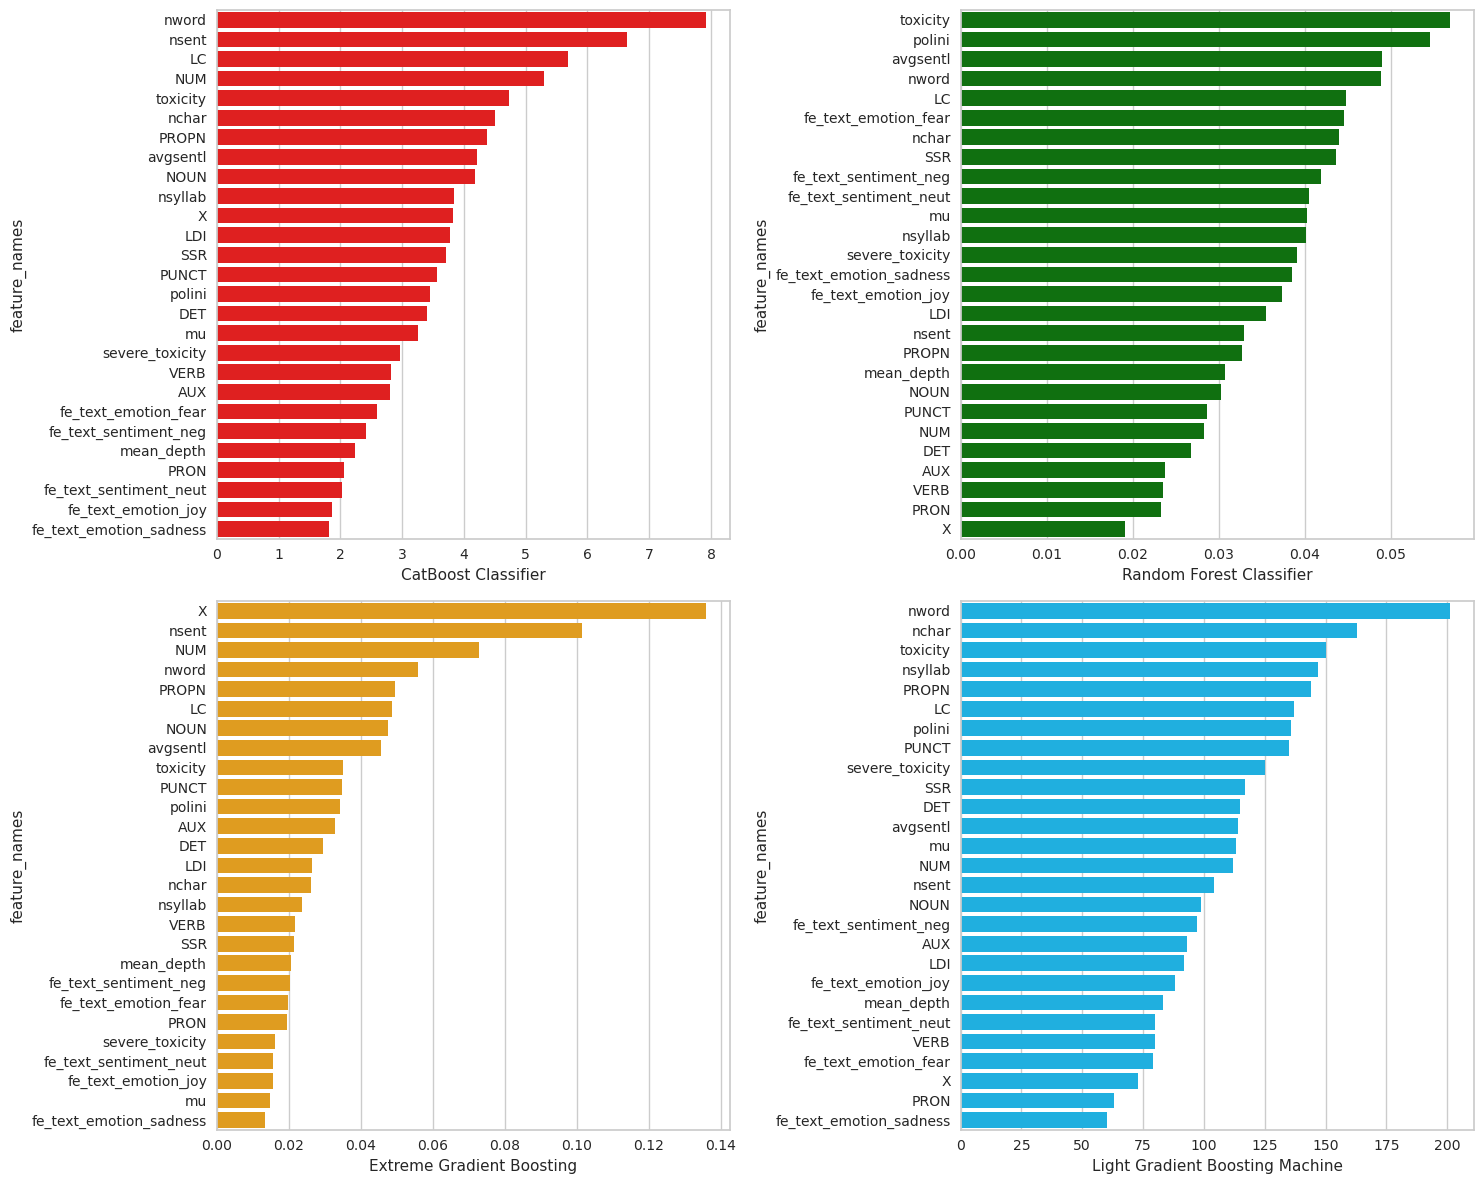

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
def plot_feature_importance(importance,names,model_type,i, j, col):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=axs[i][j], color=col)
    axs[i][j].set_xlabel(model_type)

plot_feature_importance(best_model[0].feature_importances_, best_model[0].feature_names_,'CatBoost Classifier', 0, 0, col="red")
plot_feature_importance(best_model[1].feature_importances_, best_model[1].feature_names_in_,'Random Forest Classifier', 0, 1, col="green")
plot_feature_importance(best_model[2].feature_importances_, best_model[2].feature_names_in_,'Extreme Gradient Boosting', 1, 0, col="orange")
plot_feature_importance(best_model[3].feature_importances_, best_model[3].feature_name_,'Light Gradient Boosting Machine', 1, 1, col="deepskyblue")
plt.tight_layout()
plt.show()

__Most relevant features__

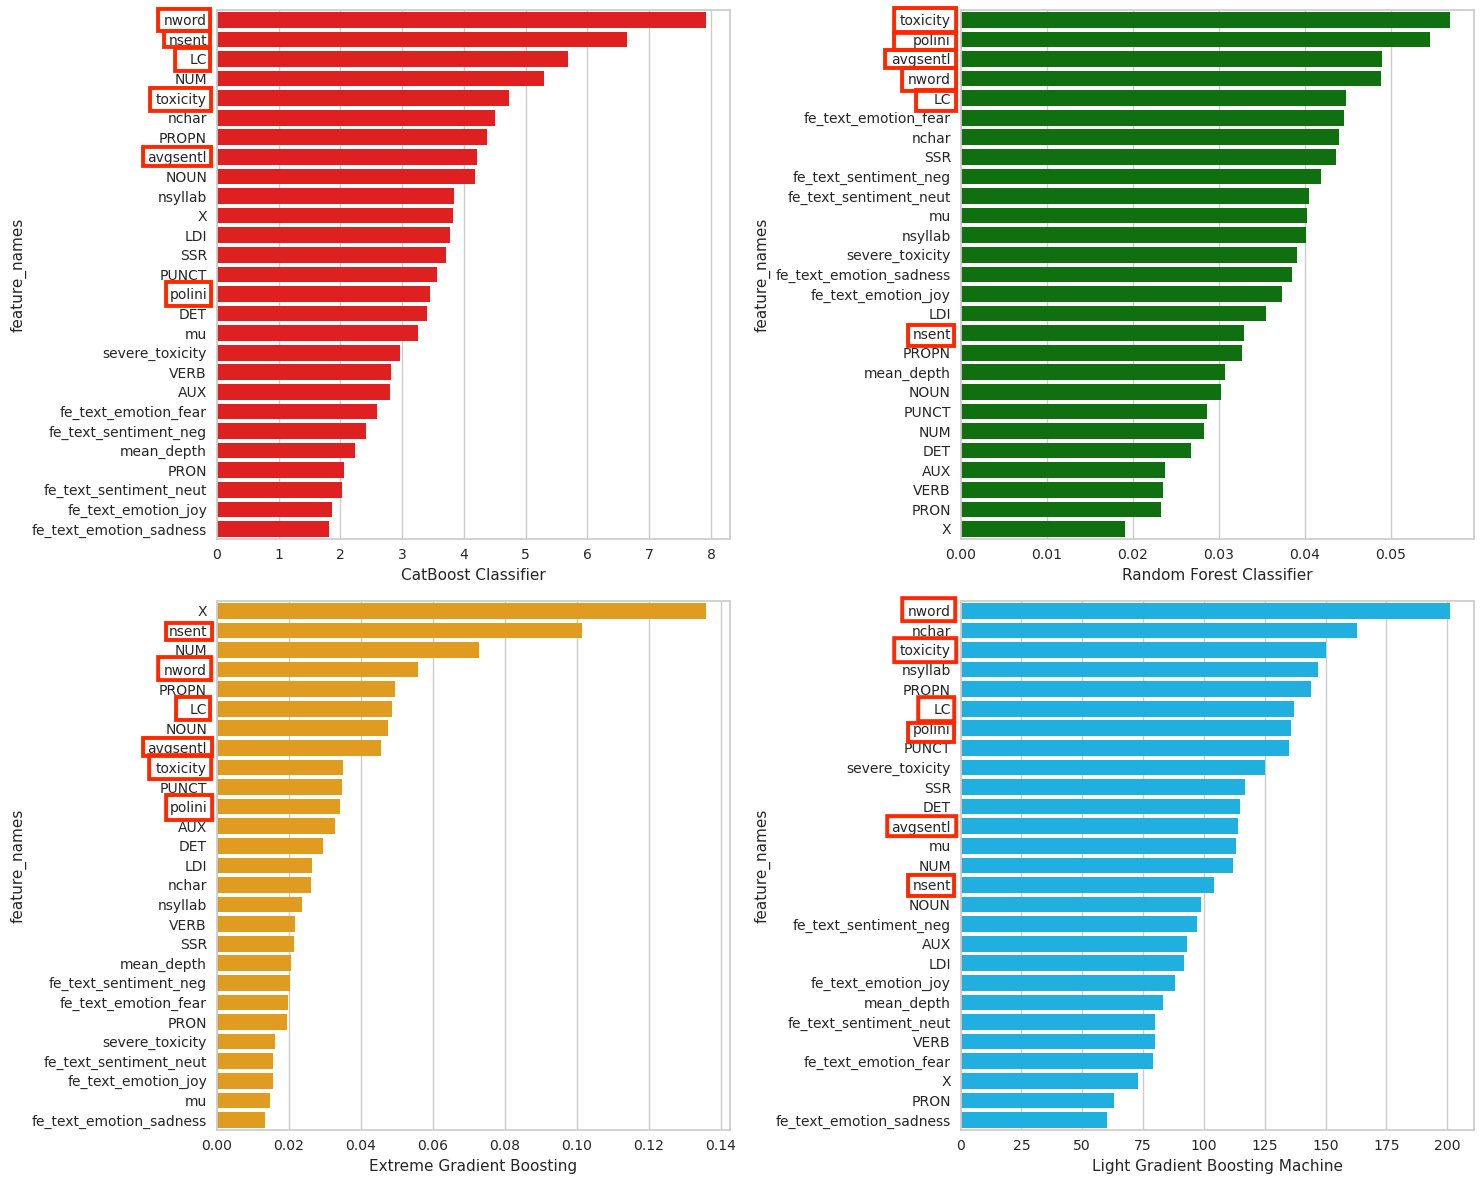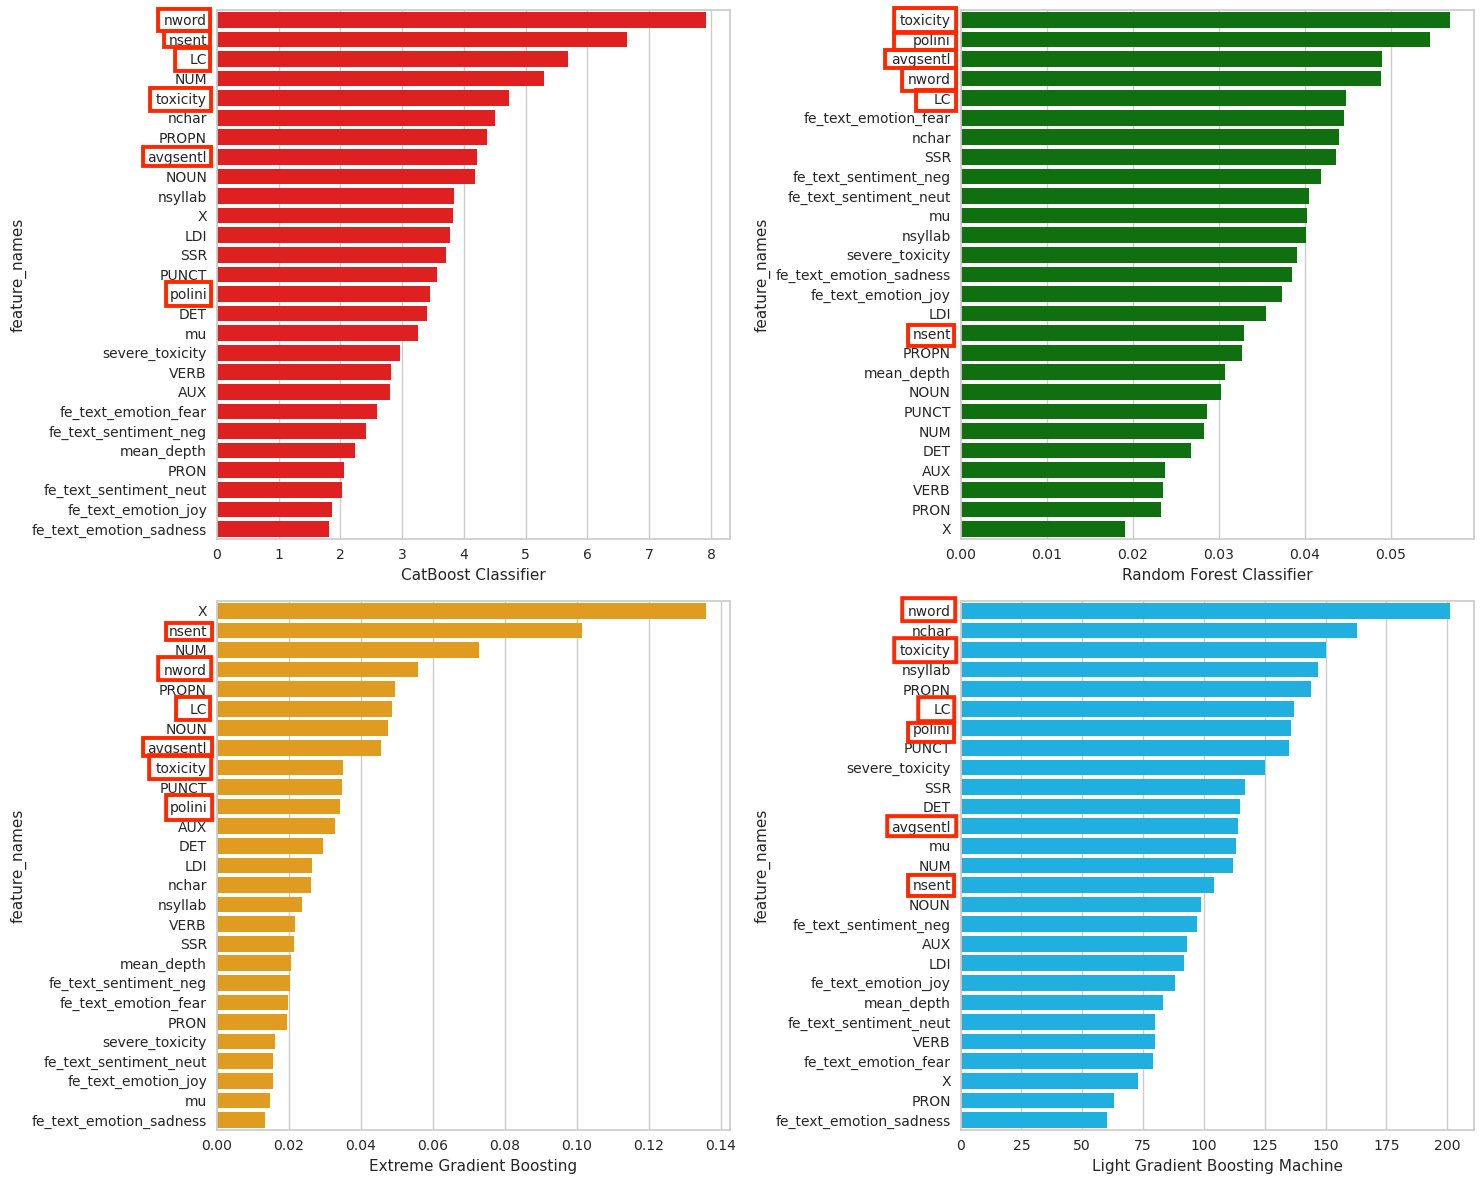

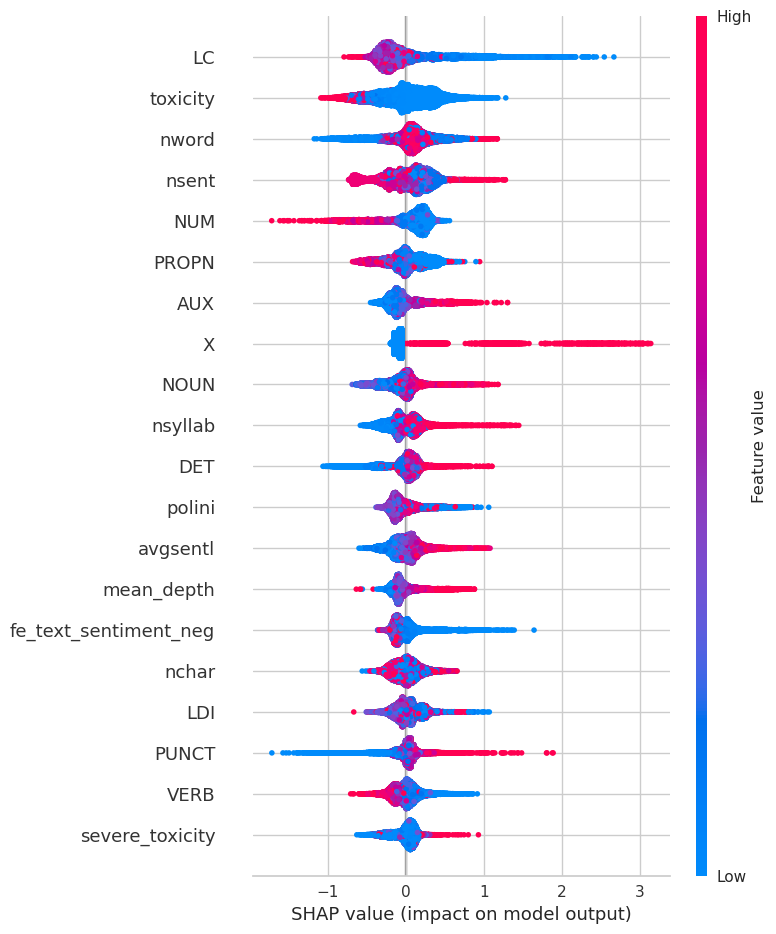

In [56]:
interpret_model(best_model[0])

## Train new model using transformer + metadata

* External metadata:
    * nsent: Number of sentences
    * nword: Number of words
    * LC: Lexical Complexity Index
    * avgsentl: Average sentence length
    * polini: Polini's compressibility 

## Dataset

In [6]:
class MyDataset(Dataset):
  def __init__(self, df):
    self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
    self.df = df    
    self.fe_nsent = self.df.loc[:, 'nsent']
    self.fe_nword = self.df.loc[:, 'nword']
    self.fe_lc    = self.df.loc[:, 'LC']
    self.fe_avgsentl = self.df.loc[:, 'avgsentl']
 
    self.fe_nsent_train    = torch.tensor(self.fe_nsent,dtype=torch.float32)
    self.fe_nword_train    = torch.tensor(self.fe_nword,dtype=torch.float32)
    self.fe_lc_train       = torch.tensor(self.fe_lc,dtype=torch.float32)
    self.fe_avgsentl_train = torch.tensor(self.fe_avgsentl,dtype=torch.float32)
    self.labels            = torch.tensor(self.df['label'],dtype=torch.float32)
 
  def __len__(self):
    return self.df.shape[0]
   
  def __getitem__(self,idx):
    text_tokenized = self.bert_tokenizer(self.df.loc[idx, 'text'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    return text_tokenized['input_ids'].squeeze().to(device), text_tokenized['attention_mask'].squeeze().to(device), \
self.fe_nsent_train[idx].to(device).unsqueeze(-1), self.fe_nword_train[idx].to(device).unsqueeze(-1),\
self.fe_lc_train[idx].to(device).unsqueeze(-1), self.fe_avgsentl_train[idx].to(device).unsqueeze(-1), self.labels[idx].squeeze().to(device)

In [7]:
train_dataset = MyDataset(train_df_fe)
test_dataset  = MyDataset(test_df_fe)

## DataLoader

In [8]:
# Crear cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

## Define Dataset class

In [11]:
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Cargar el modelo BERT pre-entrenado
        self.bert = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',output_hidden_states=True)
        self.bert.load_state_dict(torch.load("/kaggle/input/bert-uncased-best-model-v2/bert_uncased_best_model.pth"))
        for p in self.bert.parameters():
            p.require_grad = False
        
        # Definir una capa lineal para procesar las variables adicionales
        self.fc = nn.Sequential(
            nn.LayerNorm(4),
            nn.Linear(4, 32)
        )
        
        # Definir una capa lineal para la salida del modelo
        self.fc_out = nn.Linear(768+32, 1)
        
        # Definir una capa de activación sigmoidea para obtener la probabilidad de clasificación
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl):
        
        # Obtener la salida de BERT
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask).hidden_states[-1]
        pooled_output = torch.mean(output, dim=1)
        # pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output

        # Procesar las variables adicionales a través de una capa lineal
        fe_output = torch.cat([fe_nsent, fe_nword, fe_lc, fe_avgsentl], dim=-1)
        fe_output = self.fc(fe_output)
        
        # Concatenar las salidas de BERT y las variables adicionales
        concat_output = torch.cat([pooled_output, fe_output], dim=1)
        
        # Pasar la salida concatenada por una capa lineal y la activación sigmoidea
        logits = self.fc_out(concat_output)
        proba = self.sigmoid(logits).squeeze()
        
        return proba

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = BertBinaryClassifier().to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

## Loss + Optimizer

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

## Train and eval

In [20]:
# Iniciar el entrenamiento
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    print("Epoch {} of {}".format(epoch, EPOCHS))
    # Entrenar el modelo en el conjunto de entrenamiento
    print("Train step")
    model.train()
    for batch in tqdm(train_loader):
        # Obtener los datos de entrada y la etiqueta objetivo
        input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
        
        # Reiniciar los gradientes
        optimizer.zero_grad()
        
        # Obtener la salida del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
        loss = criterion(outputs, labels.float())
        
        # Realizar la retropropagación y la actualización de parámetros
        loss.backward()
        optimizer.step()
    
    # Evaluar el modelo en el conjunto de validación
    print("Eval step")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_true, y_pred = [], []
        for batch in tqdm(val_loader):
            # Obtener los datos de entrada y la etiqueta objetivo
            input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
            
            # Obtener la salida del modelo y calcular la pérdida
            outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
            val_loss += criterion(outputs, labels.float()).item()

            # Obtener las etiquetas predichas y las verdaderas
            pred_labels = torch.round(outputs)
            y_pred.extend(pred_labels.tolist())
            y_true.extend(labels.tolist())
        
        # Calcular la precisión, F1 y recall
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Save model if validation loss is lower than current best
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
        
        # Imprimir las estadísticas de entrenamiento y validación
        print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss/len(val_loader):.4f} - F1: {f1:.4f} - Accuracy: {accuracy:.4f} - Recall: {recall:.4f}')
    print("-" * 80)

Epoch 0 of 3
Train step


100%|██████████| 6591/6591 [1:26:53<00:00,  1.26it/s]


Eval step


100%|██████████| 412/412 [07:40<00:00,  1.12s/it]


Epoch 1/3 - Train Loss: 0.2211 - Val Loss: 0.4208 - F1: 0.8086 - Accuracy: 0.8012 - Recall: 0.8366
--------------------------------------------------------------------------------
Epoch 1 of 3
Train step


100%|██████████| 6591/6591 [1:27:03<00:00,  1.26it/s]


Eval step


100%|██████████| 412/412 [07:22<00:00,  1.07s/it]


Epoch 2/3 - Train Loss: 0.2557 - Val Loss: 0.4076 - F1: 0.8133 - Accuracy: 0.8036 - Recall: 0.8524
--------------------------------------------------------------------------------
Epoch 2 of 3
Train step


100%|██████████| 6591/6591 [1:26:49<00:00,  1.27it/s]


Eval step


100%|██████████| 412/412 [07:20<00:00,  1.07s/it]

Epoch 3/3 - Train Loss: 0.8819 - Val Loss: 0.4138 - F1: 0.7987 - Accuracy: 0.8104 - Recall: 0.7494
--------------------------------------------------------------------------------


In [13]:
# Iniciar el entrenamiento
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    print("Epoch {} of {}".format(epoch, EPOCHS))
    # Entrenar el modelo en el conjunto de entrenamiento
    print("Train step")
    model.train()
    for batch in tqdm(train_loader):
        # Obtener los datos de entrada y la etiqueta objetivo
        input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
        
        # Reiniciar los gradientes
        optimizer.zero_grad()
        
        # Obtener la salida del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
        loss = criterion(outputs, labels.float())
        
        # Realizar la retropropagación y la actualización de parámetros
        loss.backward()
        optimizer.step()
    
    # Evaluar el modelo en el conjunto de validación
    print("Eval step")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_true, y_pred = [], []
        for batch in tqdm(val_loader):
            # Obtener los datos de entrada y la etiqueta objetivo
            input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
            
            # Obtener la salida del modelo y calcular la pérdida
            outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
            val_loss += criterion(outputs, labels.float()).item()

            # Obtener las etiquetas predichas y las verdaderas
            pred_labels = torch.round(outputs)
            y_pred.extend(pred_labels.tolist())
            y_true.extend(labels.tolist())
        
        # Calcular la precisión, F1 y recall
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Save model if validation loss is lower than current best
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
        
        # Imprimir las estadísticas de entrenamiento y validación
        print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss/len(val_loader):.4f} - F1: {f1:.4f} - Accuracy: {accuracy:.4f} - Recall: {recall:.4f}')
    print("-" * 80)

Epoch 0 of 3
Train step


100%|██████████| 6591/6591 [1:26:42<00:00,  1.27it/s]


Eval step


100%|██████████| 412/412 [07:43<00:00,  1.12s/it]


Epoch 1/3 - Train Loss: 0.4758 - Val Loss: 0.4714 - F1: 0.8047 - Accuracy: 0.7716 - Recall: 0.9373
--------------------------------------------------------------------------------
Epoch 1 of 3
Train step


100%|██████████| 6591/6591 [1:26:45<00:00,  1.27it/s]


Eval step


100%|██████████| 412/412 [07:17<00:00,  1.06s/it]


Epoch 2/3 - Train Loss: 0.1599 - Val Loss: 0.4310 - F1: 0.7967 - Accuracy: 0.8046 - Recall: 0.7626
--------------------------------------------------------------------------------
Epoch 2 of 3
Train step


100%|██████████| 6591/6591 [1:26:36<00:00,  1.27it/s]


Eval step


100%|██████████| 412/412 [07:15<00:00,  1.06s/it]


Epoch 3/3 - Train Loss: 0.3853 - Val Loss: 0.4084 - F1: 0.8036 - Accuracy: 0.8165 - Recall: 0.7478
--------------------------------------------------------------------------------


In [14]:
# Iniciar el entrenamiento
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    print("Epoch {} of {}".format(epoch, EPOCHS))
    # Entrenar el modelo en el conjunto de entrenamiento
    print("Train step")
    model.train()
    for batch in tqdm(train_loader):
        # Obtener los datos de entrada y la etiqueta objetivo
        input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
        
        # Reiniciar los gradientes
        optimizer.zero_grad()
        
        # Obtener la salida del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
        loss = criterion(outputs, labels.float())
        
        # Realizar la retropropagación y la actualización de parámetros
        loss.backward()
        optimizer.step()
    
    # Evaluar el modelo en el conjunto de validación
    print("Eval step")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_true, y_pred = [], []
        for batch in tqdm(val_loader):
            # Obtener los datos de entrada y la etiqueta objetivo
            input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl, labels = batch
            
            # Obtener la salida del modelo y calcular la pérdida
            outputs = model(input_ids, attention_mask, fe_nsent, fe_nword, fe_lc, fe_avgsentl)
            val_loss += criterion(outputs, labels.float()).item()

            # Obtener las etiquetas predichas y las verdaderas
            pred_labels = torch.round(outputs)
            y_pred.extend(pred_labels.tolist())
            y_true.extend(labels.tolist())
        
        # Calcular la precisión, F1 y recall
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Save model if validation loss is lower than current best
        if (val_loss/len(val_loader)) < best_valid_loss:
            print("Val loss has improved from {} to {}".format(best_valid_loss, val_loss/len(val_loader)))
            best_valid_loss = val_loss/len(val_loader)
            torch.save(model.state_dict(), 'best_model_bert_pretrained.pt')
        else:
            print("Val loss hasn't improved")
        
        # Imprimir las estadísticas de entrenamiento y validación
        print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss/len(val_loader):.4f} - F1: {f1:.4f} - Accuracy: {accuracy:.4f} - Recall: {recall:.4f}')
    print("-" * 80)

Epoch 0 of 3
Train step


100%|██████████| 6591/6591 [1:30:04<00:00,  1.22it/s]


Eval step


100%|██████████| 412/412 [07:43<00:00,  1.12s/it]


Val loss has improved from inf to 0.5428037508526473
Epoch 1/3 - Train Loss: 1.1988 - Val Loss: 0.5428 - F1: 0.7793 - Accuracy: 0.7336 - Recall: 0.9373
--------------------------------------------------------------------------------
Epoch 1 of 3
Train step


100%|██████████| 6591/6591 [1:29:53<00:00,  1.22it/s]


Eval step


100%|██████████| 412/412 [07:37<00:00,  1.11s/it]


Val loss has improved from 0.5428037508526473 to 0.41535919640683433
Epoch 2/3 - Train Loss: 0.4227 - Val Loss: 0.4154 - F1: 0.8005 - Accuracy: 0.8080 - Recall: 0.7676
--------------------------------------------------------------------------------
Epoch 2 of 3
Train step


100%|██████████| 6591/6591 [1:29:28<00:00,  1.23it/s]


Eval step


100%|██████████| 412/412 [07:39<00:00,  1.12s/it]


Val loss has improved from 0.41535919640683433 to 0.4118623887595621
Epoch 3/3 - Train Loss: 0.1843 - Val Loss: 0.4119 - F1: 0.8165 - Accuracy: 0.8109 - Recall: 0.8383
--------------------------------------------------------------------------------


In [34]:
output = bert.to(device)(input_ids, attention_mask)